# Facial Recognition 1: Image Processing
This notebook accompanies the book "Programming Applied mathematics for Security" chapter 15: Facial recognition. The code in the cells was used to generate the figures for the first portion of the PoC (see the text for details).

You may be wondering why I did not use images from the dataset in the actual book. The dataset contains images which the original author does not hold releases and so cannot authorize their use in publications, even though the data itself is perfectly fine to use. The images I used here were instead taken from Unsplash users Hassan Khan and Reza Biazar. Thanks go to to them, and users like them, who allow their materials to be used by authors such as myself. Without their generosity the examples from this chapter would have been much harder to create. 

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 23 13:02:47 2019

@author: dreilly
"""
from matplotlib import pyplot as plt
from imutils import face_utils
import numpy as np
import pandas as pd
import imutils
import dlib
import cv2
import networkx as nx
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from shapely.geometry import Point, LineString, MultiLineString
from shapely.geometry.polygon import Polygon
from shapely.ops import triangulate
import matplotlib.patches as patches

The following cell contains several helper functions which were snipped to make the text more focused. 

The shape_to_np function for example is used in the first part of th PoC. The function's job is to create a 2D Numpy array containing x and y coordinates for each of the 68 facial markers which should be present in the shape argument. It starts by creating an array of all zeros, then loops over each point. if less than 68 points are in the shape parameter there will be an error (it means the face couldn't be properly detected).

The nodes_by_part function takes in a graph representing the facial data and returns all the nodes associated with a part_name. This is one convenient way to look up all the coordinates associated with a certain facial group. Other options such as a dictionary or DataFrame could also be used.
The named_triangle function is another helper function to deal with the graph representation. Each node is given a name based off it's facial part group and its index within the set (for example leye_0 for the first point in the left eye data) These labels are combined based on the 3 points in a triangle. While I didn't end up using these features in the data you may want to explore the tessellation path further, so I have left this code in.

In [2]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
 
    # loop over the 68 facial landmarks and convert them
    # to a tuple of (x, y) coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
 
    # return the list of (x, y) coordinates
    return coords

def nodes_by_part(G, part_name):
    return [n for n in G.nodes.keys() if G.node[n]["part"] == part_name]
    
def named_triangle(G, coordinates):
    pos_list = [G.nodes[n]["loc"] for n in G.nodes()]
    node_names = []
    for pt in coordinates[:3]:
        if pt not in pos_list:
            raise Exception("Point %s not in G!" % str(pt))
        node = G.nodes[pos_list.index(pt)]
        node_names.append(node["label"])
    return node_names

These objects are described in more detail in the text. If you look in the facial_model directory you will see there is an __init__.py file which is necessary in most cases to load the landmark model data

In [3]:
# construct the argument parser and parse the arguments
shape_predictor = "facial_model/shape_predictor_68_face_landmarks.dat"
# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor)
# load the input image, resize it, and create a grayscale working copy

The following cell show how to load the JPEG image files used in the chapter's examples.Both are resized to the same width, which automatically scales the height so the faces do not become distorted. it is important all the images in the data set are processed exactly the same way for the results to be valid.

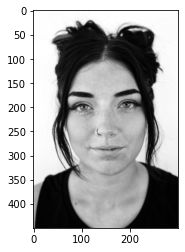

In [4]:
image1 = cv2.imread("hassan-khan-EGVccebWodM-unsplash.jpg")    
image1 = imutils.resize(image1, width=300)
image1_w, image1_h, image1_d = image1.shape
gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

image2 = cv2.imread("reza-biazar-eSjmZW97cH8-unsplash.jpg")    
image2 = imutils.resize(image2, width=300)
image2_w, image2_h, image2_d = image2.shape
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

Displaying images is typically as easy as calling the imshow function, however you should be aware that the coordinate system in images is typically different than what you are used to. in this case the origin (0,0) is in the upper left corner instead of the lower left. The y value grows as you move down the picture, not up. This will come up again in a moment.

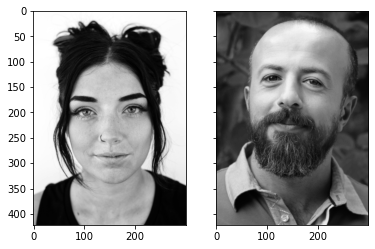

In [6]:
fig, ax = plt.subplots(1,2, sharey=True)
ax[0].imshow(gray1, cmap='gray')
ax[1].imshow(gray2, cmap='gray')

#fig.savefig("../Book_Resources/Chapter 15 - Facial Recognition/Figure_15-2.png")
#fig.savefig("../Book_Resources/Chapter 15 - Facial Recognition/Figure_15-3.svg", format="svg")
plt.show()

Just for fun let's see what happens if we set both the width and height explicitly using cv2's resize function (imutils helpfully prevents you from setting both attributes)

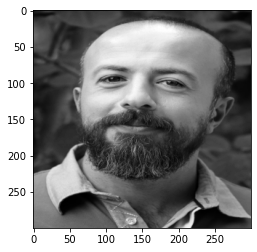

In [17]:
image_distorted = cv2.resize(image2, (300, 300))
gray_distorted = cv2.cvtColor(image_distorted, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_distorted, cmap="gray")
plt.show()

As you can see the features get stretched in a way which changes the proportions. This change would be different if the image were a different aspect ratio (the ratio of height to width) as well so even two pictures of the same face would end up altered in different ways making the measurements unusable.

The code in the next cell expands on the version from the text to support the idea of representing the face as a graph. Other than that the code is the same.

In [7]:
# detect faces in the grayscale image
rects = detector(gray1, 1)
feature_coordinates = {}
feature_npas = []
G = nx.Graph()
on = 0
# loop over the facial area rectangles
for (i, rect) in enumerate(rects):
    # determine the facial landmarks for the current region
    pred_shape = predictor(gray1, rect)
    shape_np = shape_to_np(pred_shape)
    feature_npas.append(shape_np)
    # loop over the face parts individually
    for (part_name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
        pc=1
        print("determining landmarks for: %s" % part_name)
        feature_coordinates[part_name] = []
        # loop over the subset of facial landmarks, saving each X,Y tuple
        for x, y in shape_np[i:j]:
            label = "%s_%d" % (part_name, pc)
            G.add_node(on, part=part_name, num=pc, loc=(x, y), label=label)
            feature_coordinates[part_name].append((x, y))
            on += 1
            pc += 1

face_points = [G.nodes[n]["loc"] for n in G.nodes()]
nose_points = [G.nodes[n]["loc"] for n in G.nodes() if G.nodes[n]["part"] == "nose"]
leye_points = [G.nodes[n]["loc"] for n in G.nodes() if G.nodes[n]["part"] == "left_eye"]
reye_points = [G.nodes[n]["loc"] for n in G.nodes() if G.nodes[n]["part"] == "right_eye"]
mouth_points = [G.nodes[n]["loc"] for n in G.nodes() if G.nodes[n]["part"] == "mouth"]
face_hull = ConvexHull([G.nodes[n]["loc"] for n in G.nodes()])
nose_hull = [nose_points[0]]
for p in nose_points[4:]:
    nose_hull.append(p)
nose_hull.append(nose_points[0])
nose_poly = Polygon(nose_hull)

mouth_hull = mouth_points[:12]
mouth_hull.append(mouth_points[0])
mouth_poly = Polygon(mouth_hull)
leye_poly = Polygon(leye_points)
reye_poly = Polygon(reye_points)

determining landmarks for: mouth
determining landmarks for: inner_mouth
determining landmarks for: right_eyebrow
determining landmarks for: left_eyebrow
determining landmarks for: right_eye
determining landmarks for: left_eye
determining landmarks for: nose
determining landmarks for: jaw


The next cell just duplicates the previous cell's function on the second image. The PoC wraps the whole process in a function to keep things neat.

In [8]:
# detect faces in the grayscale image
rects2 = detector(gray2, 1)
feature_coordinates2 = {}
feature_npas2 = []
G2 = nx.Graph()
on = 0
# loop over the facial area rectangles
for (i, rect) in enumerate(rects2):
    # determine the facial landmarks for the current region
    pred_shape = predictor(gray2, rect)
    shape_np = shape_to_np(pred_shape)
    feature_npas2.append(shape_np)
    # loop over the face parts individually
    for (part_name, (i, j)) in face_utils.FACIAL_LANDMARKS_IDXS.items():
        pc=1
        print("determining landmarks for: %s" % part_name)
        feature_coordinates2[part_name] = []
        # loop over the subset of facial landmarks, saving each X,Y tuple
        for x, y in shape_np[i:j]:
            label = "%s_%d" % (part_name, pc)
            G2.add_node(on, part=part_name, num=pc, loc=(x, y), label=label)
            feature_coordinates2[part_name].append((x, y))
            on += 1
            pc += 1

face_points2 = [G2.nodes[n]["loc"] for n in G2.nodes()]
nose_points2 = [G2.nodes[n]["loc"] for n in G2.nodes() if G2.nodes[n]["part"] == "nose"]
leye_points2 = [G2.nodes[n]["loc"] for n in G2.nodes() if G2.nodes[n]["part"] == "left_eye"]
reye_points2 = [G2.nodes[n]["loc"] for n in G2.nodes() if G2.nodes[n]["part"] == "right_eye"]
mouth_points2 = [G2.nodes[n]["loc"] for n in G.nodes() if G2.nodes[n]["part"] == "mouth"]
face_hull2 = ConvexHull([G2.nodes[n]["loc"] for n in G2.nodes()])
nose_hull2 = [nose_points2[0]]
for p in nose_points2[4:]:
    nose_hull2.append(p)
nose_hull2.append(nose_points2[0])
nose_poly2 = Polygon(nose_hull2)

mouth_hull2 = mouth_points2[:12]
mouth_hull2.append(mouth_points2[0])
mouth_poly2 = Polygon(mouth_hull2)
leye_poly2 = Polygon(leye_points2)
reye_poly2 = Polygon(reye_points2)

determining landmarks for: mouth
determining landmarks for: inner_mouth
determining landmarks for: right_eyebrow
determining landmarks for: left_eyebrow
determining landmarks for: right_eye
determining landmarks for: left_eye
determining landmarks for: nose
determining landmarks for: jaw


Here we calculate the convex hull for the faces as well as creating polygon patches to represent the mouth, nose, and eyes. This produces the 3rd figure in the chapter. Here is where it becomes important to remember the difference between image order and plot order, because I am not using the imshow function to plot the patches and lines there direction will be different than the image data. We can correct the plot order simply by calling the invert_yaxis function on each subplot. We can then display the image background using imshow and everything will line up as expected. The lesson here is sometimes you have to dive deeper into the display library to get the results you are after.

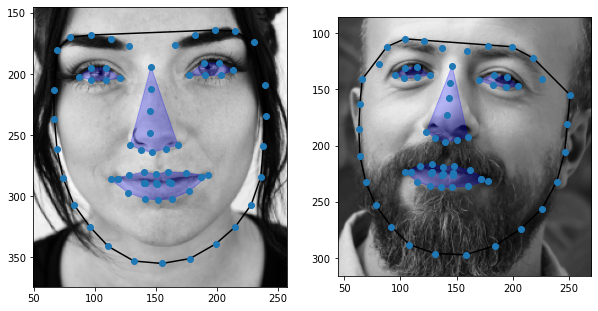

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
#ax[0].imshow(gray1, cmap='gray')
#ax[1].imshow(gray2, cmap='gray')

_ = convex_hull_plot_2d(face_hull, ax[0])
mouth_np = np.array(mouth_poly.exterior.coords)
nose_np = np.array(nose_poly.exterior.coords)
leye_np = np.array(leye_poly.exterior.coords)
reye_np = np.array(reye_poly.exterior.coords)
patch = patches.Polygon(mouth_np, color='blue', zorder=1, alpha=0.25)
ax[0].add_patch(patch) 
patch = patches.Polygon(nose_np, color='blue', zorder=1, alpha=0.25)
ax[0].add_patch(patch)
patch = patches.Polygon(leye_np, color='blue', zorder=1, alpha=0.25)
ax[0].add_patch(patch) 
patch = patches.Polygon(reye_np, color='blue', zorder=1, alpha=0.25)
ax[0].add_patch(patch)
ax[0].invert_yaxis()

_ = convex_hull_plot_2d(face_hull2, ax[1])
mouth_np2 = np.array(mouth_poly2.exterior.coords)
nose_np2 = np.array(nose_poly2.exterior.coords)
leye_np2 = np.array(leye_poly2.exterior.coords)
reye_np2 = np.array(reye_poly2.exterior.coords)
patch = patches.Polygon(mouth_np2, color='blue', zorder=1, alpha=0.25)
ax[1].add_patch(patch)
patch = patches.Polygon(nose_np2, color='blue', zorder=1, alpha=0.25)
ax[1].add_patch(patch)
patch = patches.Polygon(leye_np2, color='blue', zorder=1, alpha=0.25)
ax[1].add_patch(patch) 
patch = patches.Polygon(reye_np2, color='blue', zorder=1, alpha=0.25)
ax[1].add_patch(patch)
ax[1].invert_yaxis()

ax[0].imshow(gray1, cmap='gray')
ax[1].imshow(gray2, cmap='gray')
#plt.savefig("../Book_Resources/Chapter 15 - Facial Recognition/Figure_15-3.png")
#fig.savefig("../Book_Resources/Chapter 15 - Facial Recognition/Figure_15-3.svg", format="svg")
plt.show()

The next cell creates the tessellation example data. This was originally taken from a previous iteration of my research wherein I attempted to automatically extract the key features of the face. ultimately this proved ineffective on its own, but may prove useful if you chose to combine it with other analysis. The algorithm leverages the graph representation and the named_triangle function described previously.

/home/dreilly/anaconda3/envs/researchenv/lib/python3.7/site-packages/ipykernel_launcher.py:53: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


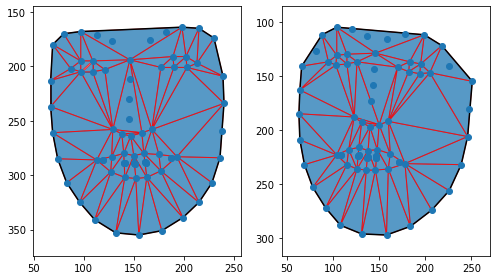

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 4))
face_hull_edges = [list(simplex) for simplex in face_hull.simplices]
face_hull_points = []
for n1_i, n2_i in face_hull_edges:
    loc_1 = face_points[n1_i]
    face_hull_points.append(loc_1)
    loc_2 = face_points[n2_i]
    face_hull_points.append(loc_2)
    node_1 = [n for n in G.nodes() if G.nodes[n]["loc"] == loc_1][0]
    node_2 = [n for n in G.nodes() if G.nodes[n]["loc"] == loc_2][0]
    if (node_1, node_2) not in G.edges.keys():
        G.add_edge(node_1, node_2)
face_poly = Polygon(face_hull_points, [
        nose_poly.exterior.coords,
        leye_poly.exterior.coords,
        reye_poly.exterior.coords,
        mouth_poly.exterior.coords
    ])
_ = convex_hull_plot_2d(face_hull, ax[0])
triangulated_face = triangulate(face_poly)

face_hull_edges = [list(simplex) for simplex in face_hull2.simplices]
face_hull_points = []
for n1_i, n2_i in face_hull_edges:
    loc_1 = face_points2[n1_i]
    face_hull_points.append(loc_1)
    loc_2 = face_points2[n2_i]
    face_hull_points.append(loc_2)
    node_1 = [n for n in G2.nodes() if G2.nodes[n]["loc"] == loc_1][0]
    node_2 = [n for n in G2.nodes() if G2.nodes[n]["loc"] == loc_2][0]
    if (node_1, node_2) not in G2.edges.keys():
        G2.add_edge(node_1, node_2)
face_poly2 = Polygon(face_hull_points, [
        nose_poly2.exterior.coords,
        leye_poly2.exterior.coords,
        reye_poly2.exterior.coords,
        mouth_poly2.exterior.coords
    ])
_ = convex_hull_plot_2d(face_hull2, ax[1])
triangulated_face2 = triangulate(face_poly2)

face_col = {}
for tri in triangulated_face:
    t_name = "-".join(named_triangle(G, tri.exterior.coords))
    t_area = tri.area
    patch = patches.Polygon(np.array(tri.exterior.coords), alpha=0.75, edgecolor="r")
    ax[0].add_patch(patch)
for tri in triangulated_face2:
    t_name = "-".join(named_triangle(G2, tri.exterior.coords))
    t_area = tri.area
    patch = patches.Polygon(np.array(tri.exterior.coords), alpha=0.75, edgecolor="r")
    ax[1].add_patch(patch)
face_series = pd.Series(face_col)
ax[0].invert_yaxis()
ax[1].invert_yaxis()
fig.tight_layout()
#plt.savefig("../Book_Resources/Chapter 15 - Facial Recognition/Figure_15-4.png")
#plt.savefig("../Book_Resources/Chapter 15 - Facial Recognition/Figure_15-4.svg", format="svg")
plt.show()